In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

### Self-attention

In [2]:
n = 15  # number of tokens
d_model, d_attn, d_value = 5, 4, 16 # dm, da, dv
scale = 1.0 / np.sqrt(d_attn)
X = torch.randn(n, d_model)
Wq = torch.randn(d_model, d_attn)
Wk = torch.randn(d_model, d_attn)
Wv = torch.randn(d_model, d_value)

def self_attention(X, Wq, Wk, Wv, scale=1.0):
    Q = X @ Wq * scale # [n, da]
    K = X @ Wk * scale # [n, da]
    V = X @ Wv # [n, dv]
    scores = Q @ K.T # or torch.einsum('il,jl->ij', Q, K); [n,n]              
    attn = torch.softmax(scores, axis=1) # [n,n]
    Y = attn @ V # or torch.einsum('ij,jd->id', attn, V); [n, dv]
    return Y

Y = self_attention(X, Wq, Wk, Wv, scale=scale)

### Tensor-based self-attention

In [3]:
Wk1 = torch.randn(d_model, d_attn)
Wk2 = torch.randn(d_model, d_attn)

def self_attention_3d(X, Wq, Wk1, Wk2, Wv):
    Q = X @ Wq # [n, da]
    K1 = X @ Wk1 # [n, da]
    K2 = X @ Wk2 # [n, da]
    V = X @ Wv # [n, dv]
    scores = torch.einsum('il,jl,kl->ijk', Q, K1, K2) # [n, n, n]
    attn = torch.softmax(scores.reshape(n, -1), dim=1).reshape(n, n, n) # [n, n, n]
    Vjk = torch.cat([V.unsqueeze(1)+V.unsqueeze(0)], dim=0) # [n, n, dv]
    Y = torch.einsum('ijk,jkd->id', attn, Vjk) # [n, dv]
    return Y

Y_3d = self_attention_3d(X, Wq, Wk1, Wk2, Wv)

### RFA Attention

In [4]:
def rff_attention(X, Wq, Wk, Wv, sigma=1.0, N=1024, eps=1e-8):
    Q = X @ Wq # [n, da]
    K = X @ Wk # [n, da]
    V = X @ Wv # [n, dv]
    omega = torch.randn(d_attn, N) / sigma # [da, N]

    def phi(T): 
        TOm = T @ omega # [n, N]
        return torch.cat([torch.cos(TOm), torch.sin(TOm)], -1) / N**0.5 # [n, 2N]

    phiQ = phi(Q)  # [n, 2N]
    phiK = phi(K)  # [n, 2N]
    CK = torch.exp((K**2).sum(axis=1, keepdims=True) / (2 * sigma**2)) # [n, 1]
    S = (phiK*CK).T @ V  # [2N, dv]
    D = torch.sum(phiK * CK, axis=0, keepdim=True) # [1, 2N]
    
    denom = phiQ @ D.T  # [n, 1]
    numer = phiQ @ S    # [n, dv]
    return numer / (denom + eps)

Y_rfa = rff_attention(X, Wq, Wk, Wv, sigma=1/scale, N=64)

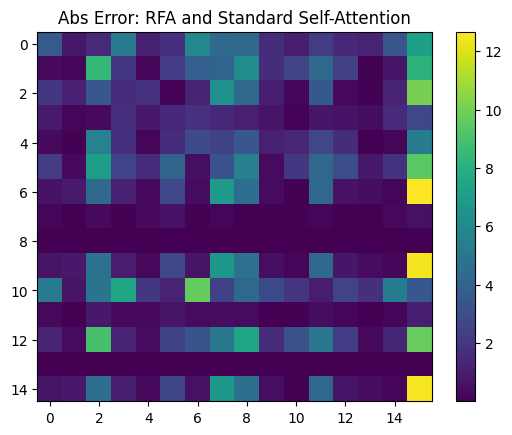

In [5]:
plt.imshow(torch.abs(Y_rfa - Y).detach().numpy())
plt.title('Abs Error: RFA and Standard Self-Attention')
plt.colorbar()

### Multidimensional RFA Kernel

In [6]:
n, d = 5, 50 # Total data points and data dimension
x = torch.randn(n, d)

def k_mc(x, sigma=1.0, N=128):
    n, d = x.shape
    diffs = x[1:] - x[0] # [n-1, d]
    omegas = torch.randn(n-1, d, N) / sigma

    m = torch.einsum('ij,ijk->ik', diffs, omegas) # [n-1, N]
    phi = torch.cat([torch.cos(m), torch.sin(m)], -1) / N**0.5 # [n-1, 2N]
    return torch.mean(torch.prod(phi, dim=0))

def k_exact(x, sigma=1.0):
    diffs = x[1:] - x[0] # [n-1, d]
    return torch.exp(-0.5 * sigma**2 * torch.sum(diffs**2))

f = lambda : torch.norm(k_mc(x, sigma=1.0, N=16) - k_exact(x, sigma=1.0)).item()
errors = np.array([f() for _ in range(1000)])
print(f"L2 Error mean: {errors.mean():.9f}", f"std: {errors.std():.9f}")

L2 Error mean: 0.000142761 std: 0.000104592


### Nystrom Method

In [7]:
n, d = 100, 5 # Total data points and data dimension
m = 20 # number of inducing points
X = torch.randn(n, d)
rbf = lambda X, Y: torch.exp(-0.5 * torch.cdist(X, Y)**2)

# Nyström approximation
C = torch.randn(m, d)
K_mm = rbf(C, C)  # [m, m]
eigvals, eigvecs = torch.linalg.eigh(K_mm)
K_mm_inv_sqrt = eigvecs @ torch.diag(1/torch.sqrt(torch.clamp(eigvals, 1e-5))) @ eigvecs.T

phi = K_mm_inv_sqrt @ rbf(X, C).T  # [N, m]
K_approx = phi.T @ phi
K_exact = rbf(X, X)

error = torch.linalg.norm(K_exact - K_approx, 'fro')/torch.linalg.norm(K_exact, 'fro')
print(f"Relative error: {error:.4f}")

Relative error: 0.7279


### Generalized Nystrom Method

In [28]:
n, d = 10, 5 # Total data points and data dimension
m = 10 # number of inducing points
X = torch.randn(n, d)

def K3(X, Y, Z):
    dXY = torch.cdist(X, Y).square().unsqueeze(2)  # [x, y, 1]
    dYZ = torch.cdist(Y, Z).square().unsqueeze(0)  # [1, y, z]
    dZX = torch.cdist(X, Z).square().unsqueeze(1)  # [x, 1, z]
    return torch.exp(-0.5 * (dXY + dYZ + dZX))

# Nyström approximation
C = torch.randn(m, d)
K_mm = K3(C, C, C)  # [m, m, m]
U, S, Vh = torch.linalg.svd(K_mm.view(m, m*m))
K_mm_inv_sqrt = U @ F.pad(torch.diag_embed(1/torch.sqrt(S.clamp_min(1e-5))), (0, m*m - m)) @ Vh

phi = K3(X, C, C).view(n, m*m) @ K_mm_inv_sqrt.T   # [N, m]
K_approx = torch.einsum('ir, jr, kr->ijk', phi, phi, phi)
K_exact = K3(X, X, X)

error = torch.mean(torch.abs(K_exact - K_approx))
print(f"Relative error: {error:.4f}")

Relative error: 0.0010


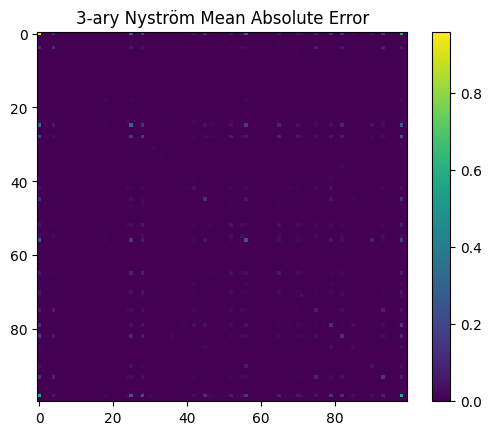

In [29]:
plt.imshow(torch.abs(K_exact - K_approx)[0].detach().numpy())
plt.colorbar()
plt.title('3-ary Nyström Mean Absolute Error')
plt.show()

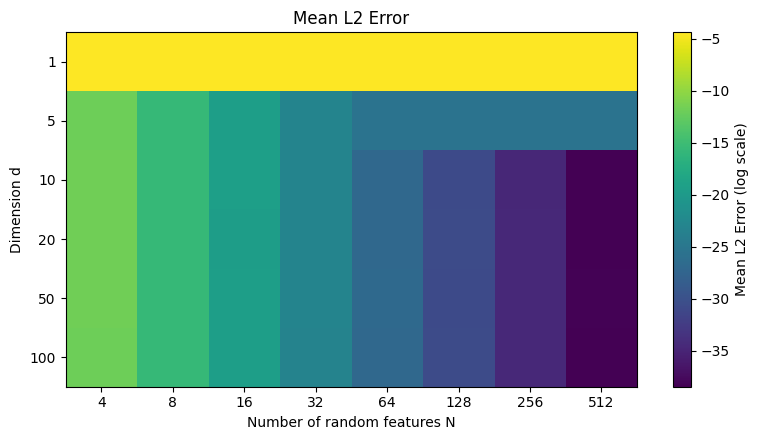

In [38]:
def k_mc(x, sigma=1.0, N=128):
    n, d = x.shape
    diffs = x  # [n, d]  (following user's original code)
    omegas = torch.randn(n, d, N) / sigma
    m = torch.einsum('ij,ijk->ik', diffs, omegas)  # [n, N]
    phi = torch.cat([torch.cos(m), torch.sin(m)], -1) / (N ** 0.5)  # [n, 2N]
    return torch.mean(torch.prod(phi, dim=0))

def k_exact(x, sigma=1.0):
    diffs = x  # [n, d]  (following user's original code)
    return torch.exp(-0.5 * sigma**2 * torch.sum(diffs**2))

def estimate_error(x, N, trials=200, sigma=1.0):
    exact = k_exact(x, sigma=sigma)
    errs = []
    for _ in range(trials):
        approx = k_mc(x, sigma=sigma, N=N)
        err = torch.norm(approx - exact).item()
        errs.append(err)
    return float(np.mean(errs))

# Grid of Ns and ds (feel free to tweak)
N_values = [4, 8, 16, 32, 64, 128, 256, 512]
d_values = [1, 5, 10, 20, 50, 100]

# Compute mean errors
mean_errors = np.zeros((len(d_values), len(N_values)), dtype=float)

n = 10      # total data points (fixed per your snippet)
sigma = 1.0

for i, d in enumerate(d_values):
    # New dataset for each dimensionality
    x = torch.randn(n, d)
    for j, N in enumerate(N_values):
        mean_errors[i, j] = estimate_error(x, N=N, trials=200, sigma=sigma)

# Plot: error heatmap
plt.figure(figsize=(8, 4.5))
im = plt.imshow(np.log(mean_errors), aspect='auto')
plt.xticks(ticks=np.arange(len(N_values)), labels=N_values)
plt.yticks(ticks=np.arange(len(d_values)), labels=d_values)
plt.xlabel("Number of random features N")
plt.ylabel("Dimension d")
plt.title("Mean L2 Error")
cbar = plt.colorbar(im)
cbar.set_label("Mean L2 Error (log scale)")
plt.tight_layout()
plt.show()